In [1]:
from grale.all_nb import *
import pandas as pd
import pickle
import matplotlib.pyplot as plt

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [2]:
zd = 0.3480
cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)

# Load the result from the grale based parametric inversion, from the MCMC step
inv = lenses.GravitationalLens.load("mcmcInv.lensdata")

In [3]:
# Prepare LensInfo object, to plot the results
li = plotutil.LensInfo(inv, size=100*ANGLE_ARCSEC)

In [4]:
# Load the input images, and add them to an InversionWorkSpace (will be
# used to backproject the images)
def la(line):
    parts = line.split()
    src, img = map(int, parts[0].split("."))
    ra, dec = float(parts[1])*ANGLE_DEGREE, float(parts[2])*ANGLE_DEGREE
    z = float(parts[3])

    return { "srcnr": src, "imgnr": img, "x": ra, "y": dec, "z": z}

ctr = V(342.183210, -44.530878)*ANGLE_DEGREE
imgList = images.readInputImagesFile("./images.txt", True, la, ctr)

iws = inversion.InversionWorkSpace(zd, 100*ANGLE_ARCSEC)
for i in imgList:
    iws.addImageDataToList(i["imgdata"], i["z"], "pointimages")

Text(value='')

FloatProgress(value=0.0)

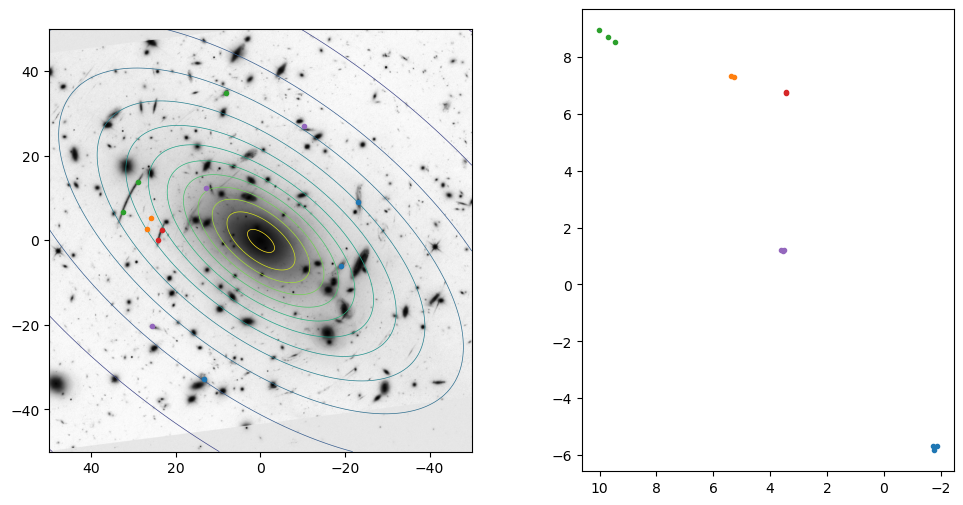

In [5]:
# The mass map of the GRALE based solution, as well as the backprojected images
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(plt.imread("100x100gray_inv.jpg"), extent=[50,-50,-50,50])
plotutil.plotDensityContours(li, levels=np.arange(0, np.max(li.getDensityPixels()), 0.5), linewidths=[0.5])
plotutil.plotImagesData(imgList)
plt.gca().invert_xaxis()
plt.subplot(1,2,2)
plotutil.plotImagesData(iws.backProject(inv))
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal")

In [6]:
# A helper function to print the properties of the solutions
def printLens(l):
    compParams = l.getLensParameters()
    assert len(compParams) == 1
    piemd = compParams[0]["lens"]
    piemdParams = piemd.getLensParameters()
    x, y, angle = compParams[0]["x"]/ANGLE_ARCSEC, compParams[0]["y"]/ANGLE_ARCSEC, compParams[0]["angle"]
    velDisp = piemd.getVelocityDispersion()/1000
    ell = piemd.getEllipticity()
    core = piemdParams["coreradius"]/ANGLE_ARCSEC
    cut = piemdParams["scaleradius"]/ANGLE_ARCSEC
    print(f"""x:           {x:.5g} arcsec
y:           {y:.5g} arcsec
angle:       {angle:.5g} deg
veldisp:     {velDisp:.5g} km/s
corerad:     {core:.5g} arcsec
cutrad:      {cut:.5g} arcsec
ellipticity: {ell:.5g}""")

In [7]:
# Show the properties of the best solution from the GRALE parametric inversion,
# as well as the RMS
printLens(inv)
rms = util.calculateRMS(util.calculateImagePredictions(imgList, inv, cosmology=cosm), ANGLE_ARCSEC)["full"]
print(f"\nRMS: {rms:.3g} arcsec")

x:           -0.13137 arcsec
y:           -0.15217 arcsec
angle:       37.777 deg
veldisp:     1241.4 km/s
corerad:     16.049 arcsec
cutrad:      2000 arcsec
ellipticity: 0.62567

RMS: 0.334 arcsec


In [8]:
# Up till now we were just looking at the best solution that was encountered during the
# MCMC routine. But the samples from the MCMC chains were written out as well, so we can
# generate some statistical information

# Read the information about the parameters that were being optimized. This was written
# in the inversion script, and it contains a name for each parameter in the samples file
# as well as a scale factor. This scale factor is needed to convert the values from the
# samples file to regular units, as they use some arbitratry units to keep the calculated
# values in a sensible range
paramInfo = pickle.load(open("./paraminfo.dat", "rb"))
names = [ x["name"] for x in paramInfo ]
scales = np.array([ x["scalefactor"] for x in paramInfo ]).reshape((1,-1))
list(zip(names,scales[0,]))

[('x_0_scaled', np.float64(0.0048481368110953596)),
 ('y_0_scaled', np.float64(0.0048481368110953596)),
 ('angle_0', np.float64(57.29577951308232)),
 ('lens_0,centraldensity_scaled', np.float64(3.42173433199946)),
 ('lens_0,coreradius_scaled', np.float64(0.0048481368110953596)),
 ('lens_0,epsilon', np.float64(1.0))]

In [9]:
# Read the samples file, reshape it so that it has some amount of rows, each containing the
# values for the parameters in the sample. The amount of values per sample is ultimately
# obtained fro the "paraminfo.dat" file
samples = np.fromfile("samples.dat", dtype=np.float32).reshape((-1,len(names))).astype(np.float64)
# Rescale the values to get the correct units
scaledSamples = samples*scales

In [10]:
# Here we'll first build a pandas dataframe from these values. We'll rework the centraldensity values to
# velocity dispersion values, and epsilon values to ellipticity values, to illustrate how this can be
# done. We'll also rename and rescale some other columns

df = pd.DataFrame(scaledSamples, columns=names).copy()
# Use velocitydispersion and ellipticity instead of centraldensity and epsilon
df["velocitydispersion_km_s"] = lenses.PIEMDLens.getVelocityDispersionFromCentralDensity(
    df["lens_0,centraldensity_scaled"], df["lens_0,coreradius_scaled"], 2000*ANGLE_ARCSEC, inv.getLensDistance()
)/1000
df["ellipticity"] = lenses.PIEMDLens.getEllipticityFromEpsilon(df["lens_0,epsilon"])
del df["lens_0,epsilon"]
del df["lens_0,centraldensity_scaled"]

# Scale to arcsec for convenience
df["x_arcsec"] = df["x_0_scaled"]/ANGLE_ARCSEC
df["y_arcsec"] = df["y_0_scaled"]/ANGLE_ARCSEC
df["coreradius_arcsec"] = df["lens_0,coreradius_scaled"]/ANGLE_ARCSEC

del df["x_0_scaled"]
del df["y_0_scaled"]
del df["lens_0,coreradius_scaled"]

df["angle_degree"] = df["angle_0"]
del df["angle_0"]

In [11]:
# For one particular column this estimates the mean and standard deviation
# and plots the histogram
def plotHist(df, colName):
    data = df[colName]

    q25, q75 = np.percentile(data, [25, 75])
    mu = (q25 + q75)/2
    sigma = (q75 - q25)/(2 * 0.6745)

    rnge = [mu-5*sigma,mu+5*sigma]
    plt.hist(data, bins=100, density=True, range=rnge)
    plt.gca().set_xlim(rnge)
    x = np.linspace(*rnge, 1000)
    y = 1/((2*np.pi)**0.5*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))
    plt.plot(x, y)
    plt.title(f"{colName}: mu = {mu:.5g}, sigma = {sigma:.5g}")

    print(f"{colName}: {mu:.5g} +/- {sigma:.5g}")

velocitydispersion_km_s: 1233.4 +/- 32.704
ellipticity: 0.6482 +/- 0.046233
x_arcsec: -0.4032 +/- 1.041
y_arcsec: -0.35536 +/- 0.74831
coreradius_arcsec: 15.436 +/- 2.1323
angle_degree: 37.681 +/- 0.70879


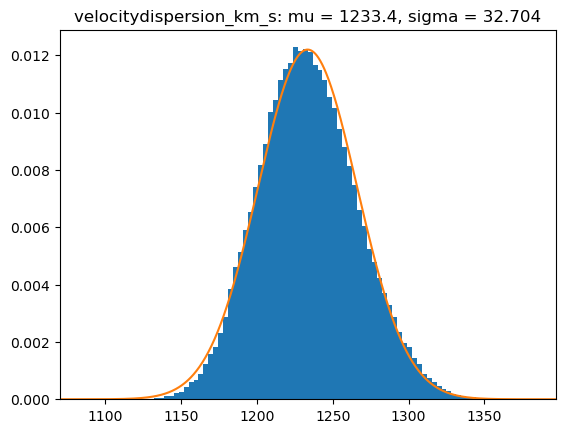

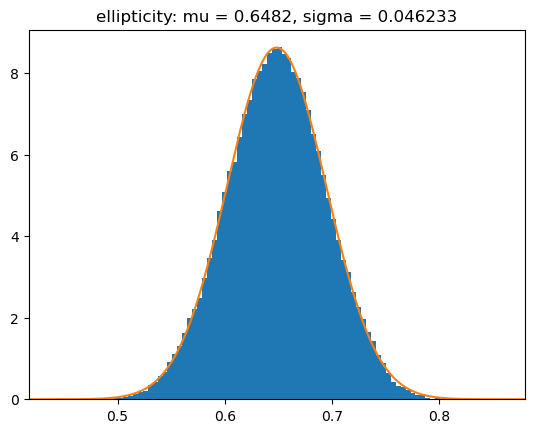

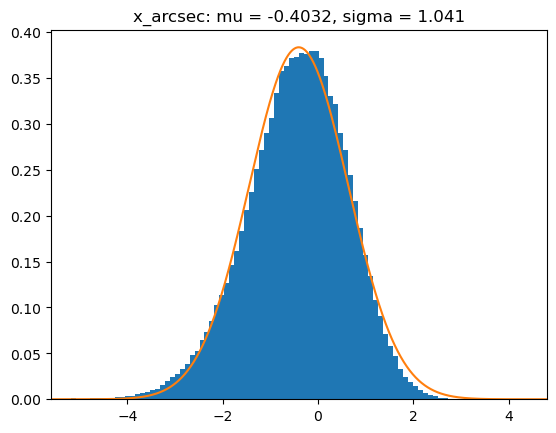

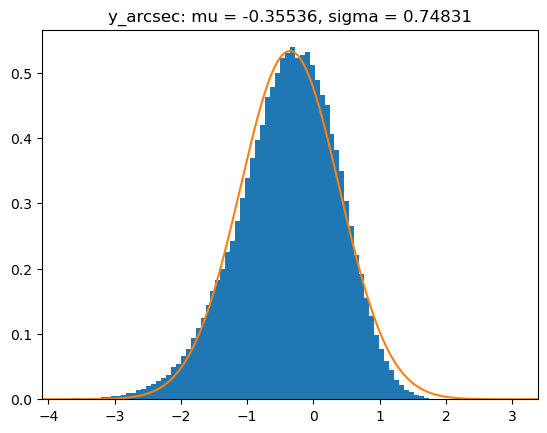

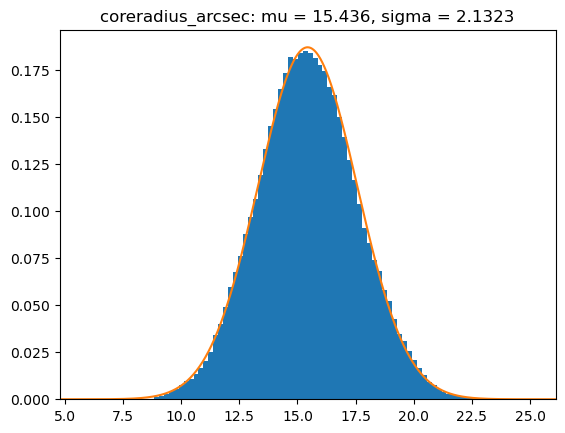

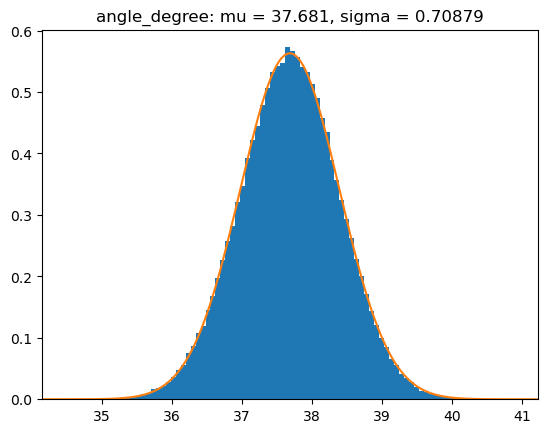

In [12]:
# For each column in the dataframe above, plot such a histogram
for n in df.columns:
    plt.figure()
    plotHist(df, n)